In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import numpy as np
# ---- ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ----
# (Windows) Î≥¥ÌÜµ 'Malgun Gothic'
plt.rc('font', family='Malgun Gothic')  
# (Mac) Î≥¥ÌÜµ 'AppleGothic'
# plt.rc('font', family='AppleGothic')
# (Linux, Colab) ÎÇòÎàîÍ∏ÄÍº¥ Í≤ΩÎ°ú ÏßÄÏ†ï ÌïÑÏöîÌï† Ïàò ÏûàÏùå
# plt.rc('font', family='NanumGothic')

plt.rc('axes', unicode_minus=False)  # ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ

# sliding Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="Malgun Gothic")

train_df= pd.read_csv("../data/processed/train_sliding_sales.csv", encoding="utf-8")
test_df = pd.read_csv("../data/processed/test_sliding_sales.csv", encoding="utf-8")



In [3]:
print(list(train_df.columns))

['num', 'biz_type', 'market', 'is_franchise', 'open', 'is_cold_start', 'is_market_missing', 'biz_type_adj', 'market_adj', 'base_ym', 'target_ym', 'y', 'oper_month_grp_mean', 'sales_grp_mean', 'txn_cnt_grp_mean', 'cust_cnt_grp_mean', 'avg_pay_grp_mean', 'cancel_rate_grp_mean', 'delivery_sales_ratio_mean', 'rel_sales_ratio_mean', 'rel_txn_ratio_mean', 'sales_rank_industry_mean', 'sales_rank_market_mean', 'share_sales_industry_mean', 'share_sales_market_mean', 'male_20below_ratio_mean', 'male_30_ratio_mean', 'male_40_ratio_mean', 'male_50_ratio_mean', 'male_60plus_ratio_mean', 'female_20below_ratio_mean', 'female_30_ratio_mean', 'female_40_ratio_mean', 'female_50_ratio_mean', 'female_60plus_ratio_mean', 'revisit_ratio_mean', 'new_ratio_mean', 'resident_ratio_mean', 'worker_ratio_mean', 'floating_ratio_mean', 'sales_estimate_mean', 'is_customer_missing_mean', 'is_behavior_missing_mean', 'is_type_missing_mean', 'is_delivery_missing_mean', 'oper_month_grp_std', 'sales_grp_std', 'txn_cnt_grp_

# Mixture of Expert(MoE)

In [4]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


# 1. Feature Split (X and Z) and Preprocessing

In [5]:
import pandas as pd

# Define gate input features (Z) - last-month summary metrics and key indicators
Z_features = [
    'sales_grp_last',  'cust_cnt_grp_last', 'avg_pay_grp_last',
    'delivery_sales_ratio_last', 'new_ratio_last' ,'cancel_rate_grp_last', 'share_sales_industry_last','is_franchise',
    'revisit_ratio_last'  #, 'gmm_cluster_bizonly'  #,'sales_estimate_last','is_cold_start'
]

# Define expert input features (X) - 3-month averages, std devs, and detailed ratios
X_features = [
    'sales_grp_mean', 'txn_cnt_grp_mean', 'cust_cnt_grp_mean', 'avg_pay_grp_mean','cancel_rate_grp_mean','share_sales_industry_mean',
    'sales_grp_std', 'txn_cnt_grp_std', 'sales_estimate_mean', 'sales_estimate_std',
    'delivery_sales_ratio_mean', 'new_ratio_mean', 'revisit_ratio_mean',
    'resident_ratio_mean', 'worker_ratio_mean', 'floating_ratio_mean',
    'rel_sales_ratio_mean', 'rel_txn_ratio_mean',
    'is_customer_missing_mean', 'is_behavior_missing_mean',
    'is_type_missing_mean', 'is_delivery_missing_mean',
    "male_20below_ratio_mean", "male_30_ratio_mean", "male_40_ratio_mean",
    "male_50_ratio_mean", "male_60plus_ratio_mean",
    "female_20below_ratio_mean", "female_30_ratio_mean", "female_40_ratio_mean",
    "female_50_ratio_mean", "female_60plus_ratio_mean"
]
# Add demographic customer ratio means (drop one to avoid sum=100% collinearity)
#demo_ratio_feats = [f'{gender}_{age}_ratio_mean' 
                    #for gender in ['male','female'] for age in ['20below','30','40','50','60plus']]
#demo_ratio_feats.remove('female_60plus_ratio_mean')  # drop one redundant feature
#X_features += demo_ratio_feats

# (Optional) Verify that all selected features exist in the data
for col in Z_features + X_features:
    if col not in train_df.columns:
        print(f"Feature {col} not found in dataset!")
# Fill any missing values with 0 (since missing indicators are present to inform the models)
train_df.fillna(0.0, inplace=True)
test_df.fillna(0.0, inplace=True)


In [6]:
# ÏòàÏãú: df.columns, X_features, Z_featuresÍ∞Ä ÏûàÎã§Í≥† Í∞ÄÏ†ï
excluded_features = set(train_df.columns) - set(X_features) - set(Z_features)

# Í≤∞Í≥ºÎ•º Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
excluded_features = list(excluded_features)

print(excluded_features)


['worker_ratio_std', 'is_market_missing', 'biz_type', 'is_behavior_missing_last', 'target_ym', 'resident_ratio_std', 'share_sales_market_std', 'male_30_ratio_last', 'market', 'cancel_rate_grp_std', 'male_30_ratio_std', 'sales_rank_industry_last', 'female_20below_ratio_std', 'is_type_missing_std', 'oper_month_grp_mean', 'female_60plus_ratio_std', 'is_cold_start', 'share_sales_market_mean', 'male_60plus_ratio_last', 'worker_ratio_last', 'txn_cnt_grp_last', 'male_50_ratio_std', 'biz_type_adj', 'floating_ratio_last', 'market_adj', 'is_type_missing_last', 'y', 'male_40_ratio_std', 'is_customer_missing_std', 'female_50_ratio_std', 'base_ym', 'rel_txn_ratio_last', 'floating_ratio_std', 'num', 'male_20below_ratio_std', 'male_60plus_ratio_std', 'sales_rank_industry_std', 'female_60plus_ratio_last', 'female_40_ratio_std', 'sales_rank_industry_mean', 'sales_rank_market_std', 'female_20below_ratio_last', 'is_delivery_missing_last', 'oper_month_grp_last', 'female_50_ratio_last', 'open', 'sales_esti

# 2. Store Clustering with GMM (Expert Clusters)

In [7]:
# Number of expert clusters (could be tuned using BIC/AIC)
#kÏßÄÏ†ï 
K = 10

In [8]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler




# Scale the X features for clustering
scaler = StandardScaler()
X_train = train_df[X_features].values
X_train_scaled = scaler.fit_transform(X_train)

# Fit Gaussian Mixture Model on the scaled X features
gmm = GaussianMixture(n_components=K, random_state=42)
gmm.fit(X_train_scaled)

# Obtain soft cluster assignments (probabilities) and hard labels for training data
cluster_probs_train = gmm.predict_proba(X_train_scaled)   # shape: [n_samples, K]
cluster_labels_train = gmm.predict(X_train_scaled)        # most likely cluster index for each sample

# Append the cluster label to the training DataFrame for reference (optional)
train_df['moe_cluster_label'] = cluster_labels_train


# 3. Gate Model Training (Z ‚Üí Cluster Probability)

In [9]:
from xgboost import XGBClassifier

# Train the gate model to predict cluster labels from Z features
gate_model = XGBClassifier(objective='multi:softprob', num_class=K, 
                           use_label_encoder=False, eval_metric='mlogloss', random_state=42)
Z_train = train_df[Z_features].values  # gate input features for training
gate_model.fit(Z_train, cluster_labels_train)

# Example: gate_model.predict_proba(Z_train[:5])  -> softmax probabilities for the first 5 samples


c:\Users\eunseok\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:44:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=10, ...)

# 4. Expert Models Training (X ‚Üí y for each cluster)

In [10]:
from xgboost import XGBRegressor

# Train one XGBRegressor per cluster on the corresponding subset of training data
expert_models = []
for k in range(K):
    # Select data for cluster k
    X_train_k = train_df.loc[train_df['moe_cluster_label'] == k, X_features].values
    y_train_k = train_df.loc[train_df['moe_cluster_label'] == k, 'y'].values
    # Train expert k
    expert = XGBRegressor(objective='reg:squarederror', random_state=42)
    expert.fit(X_train_k, y_train_k)
    expert_models.append(expert)


# 5. Mixture-of-Experts Prediction on New Data

In [11]:
class MoEModel:
    def __init__(self, X_features, Z_features, n_clusters):
        self.X_features = X_features
        self.Z_features = Z_features
        self.n_clusters = n_clusters
        self.gate_model = None
        self.expert_models = []
        self.scaler = StandardScaler()  # for scaling X features for GMM (if needed)
        self.gmm = None

    def fit(self, data):
        # Prepare X for clustering and scale it
        X_data = data[self.X_features].fillna(0.0).values
        X_scaled = self.scaler.fit_transform(X_data)
        # Fit GMM to X features
        self.gmm = GaussianMixture(n_components=self.n_clusters, random_state=42)
        self.gmm.fit(X_scaled)
        cluster_labels = self.gmm.predict(X_scaled)
        # Train gate model (Z -> cluster label)
        Z_data = data[self.Z_features].fillna(0.0).values
        self.gate_model = XGBClassifier(objective='multi:softprob', num_class=self.n_clusters,
                                        use_label_encoder=False, eval_metric='mlogloss', random_state=42)
        self.gate_model.fit(Z_data, cluster_labels)
        # Train expert models for each cluster
        y = data['y'].values
        for k in range(self.n_clusters):
            X_k = X_data[cluster_labels == k]
            y_k = y[cluster_labels == k]
            expert = XGBRegressor(objective='reg:squarederror', random_state=42)
            expert.fit(X_k, y_k)
            self.expert_models.append(expert) ## ‚Üê yÎ°ú ÌïôÏäµÌïòÎäî Î∂ÄÎ∂Ñ

    def predict(self, data):
        Z_data = data[self.Z_features].fillna(0.0).values
        X_data = data[self.X_features].fillna(0.0).values
        # Gate: predict cluster probabilities
        cluster_prob = self.gate_model.predict_proba(Z_data)    # shape [n_samples, K]
        cluster_pred = np.argmax(cluster_prob, axis=1)          # predicted cluster index (highest prob)
        # Experts: predict sales for each cluster model
        expert_preds = np.vstack([model.predict(X_data) for model in self.expert_models]).T  # shape [n_samples, K]
        # Weighted sum of expert predictions
        y_pred = np.sum(cluster_prob * expert_preds, axis=1)
        # Build result DataFrame
        result = pd.DataFrame({'moe_cluster': cluster_pred, 'y_pred': y_pred})
        # Add cluster probability columns for each cluster k
        for k in range(self.n_clusters):
            result[f'moe_p_{k}'] = cluster_prob[:, k]
        return result

# Initialize and train the MoE model on the training set
moe_model = MoEModel(X_features=X_features, Z_features=Z_features, n_clusters=K)
moe_model.fit(train_df)

# Generate predictions on the test set
test_results = moe_model.predict(test_df)

# Append identifying info if needed
test_results = pd.concat([test_df[['num','base_ym','target_ym']].reset_index(drop=True), test_results], axis=1)
print(test_results.head(5))


c:\Users\eunseok\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:44:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


          num     base_ym   target_ym  moe_cluster        y_pred   moe_p_0  \
0  000F03E44A  2024-08-01  2024-09-01            1  15906.551758  0.000032   
1  000F03E44A  2024-09-01  2024-10-01            8   2766.532227  0.000204   
2  000F03E44A  2024-10-01  2024-11-01            3   2385.349609  0.000051   
3  002816BA73  2024-08-01  2024-09-01            0  21300.462891  0.953193   
4  002816BA73  2024-09-01  2024-10-01            0  27535.074219  0.954050   

    moe_p_1   moe_p_2   moe_p_3   moe_p_4   moe_p_5   moe_p_6   moe_p_7  \
0  0.731746  0.001259  0.000169  0.266196  0.000036  0.000029  0.000013   
1  0.000419  0.000642  0.361301  0.021291  0.000038  0.004672  0.004261   
2  0.008212  0.000006  0.760156  0.017410  0.000004  0.006262  0.000022   
3  0.000002  0.000273  0.021293  0.000434  0.000010  0.008041  0.001420   
4  0.000002  0.000269  0.022406  0.000811  0.000009  0.008427  0.001172   

    moe_p_8   moe_p_9  
0  0.000414  0.000108  
1  0.606722  0.000450  
2  0.207

# 6. Î™®Îç∏ ÌèâÍ∞Ä

## 6-1 train ÌèâÍ∞Ä

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ÏòàÏ∏° ÏàòÌñâ (train Í∏∞Ï§Ä ÏÑ±Îä• ÌèâÍ∞Ä)
train_preds = moe_model.predict(train_df)
y_true = train_df['y'].values
y_pred = train_preds['y_pred'].values

# ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"[Train ÏÑ±Îä•]")
print(f"MAE  : {mae:,.0f}")
print(f"RMSE : {rmse:,.0f}")
print(f"R¬≤   : {r2:.4f}")


[Train ÏÑ±Îä•]
MAE  : 4,379
RMSE : 7,878
R¬≤   : 0.9657


c:\Users\eunseok\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 6-2 test ÌèâÍ∞Ä

In [13]:
test_preds = moe_model.predict(test_df)
y_true_test = test_df['y'].values
y_pred_test = test_preds['y_pred'].values

print(f"[Test ÏÑ±Îä•]")
print(f"MAE  : {mean_absolute_error(y_true_test, y_pred_test):,.0f}")
print(f"RMSE : {mean_squared_error(y_true_test, y_pred_test, squared=False):,.0f}")
print(f"R¬≤   : {r2_score(y_true_test, y_pred_test):.4f}")


[Test ÏÑ±Îä•]
MAE  : 9,696
RMSE : 20,620
R¬≤   : 0.7875


c:\Users\eunseok\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 6-3 confusion matrix

[Gate vs GMM] Confusion matrix:
[[14606     0     5     2     0     1   109   119    62   374]
 [    0   930     0     6     2    17     0     0     6   122]
 [   55     0   393     9     1     3     3     1     0    11]
 [  985     0     0  8313     1     0    80    18    46    45]
 [   23    29     0    13   324    29    10     1    29   177]
 [    7    18     0     0     1   527     0     1     0   335]
 [  414     0     2   419     1     0  2436     2    49    16]
 [  531     0     0    87     0     2     3  1470    12    83]
 [  407     5     0   233     7     0    28    12  1462   145]
 [  388     4     0     0     7    91     2    59    36  4594]]


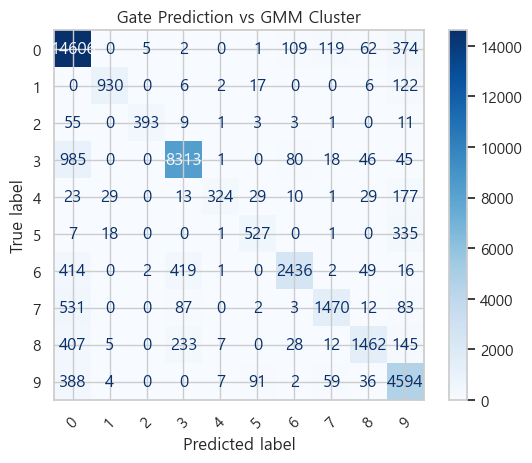

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# GMM Í∏∞Ï§Ä Ïã§Ï†ú ÌÅ¥Îü¨Ïä§ÌÑ∞ (hard label)
X_scaled = moe_model.scaler.transform(train_df[moe_model.X_features].values)
true_clusters = moe_model.gmm.predict(X_scaled)

# GateÍ∞Ä ÏòàÏ∏°Ìïú ÌÅ¥Îü¨Ïä§ÌÑ∞ (softmax argmax)
Z_data = train_df[moe_model.Z_features].values
gate_pred_clusters = moe_model.gate_model.predict(Z_data)

# Confusion matrix
cm = confusion_matrix(true_clusters, gate_pred_clusters)
print("[Gate vs GMM] Confusion matrix:")
print(cm)

# ÏãúÍ∞ÅÌôî (ÏÑ†ÌÉù)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Gate Prediction vs GMM Cluster")
plt.show()


In [15]:
import pandas as pd

# Train Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÌè¨ ÌôïÏù∏ (Gate Í∏∞Î∞ò soft routing)
train_preds = moe_model.predict(train_df)
df_check = train_df.copy()
df_check["moe_cluster"] = train_preds["moe_cluster"]

# Î∂ÑÌè¨ Ï∂úÎ†• (ÎπÑÏú® Ìè¨Ìï®)
print("[Cluster ÎπÑÏú®]")
print(df_check["moe_cluster"].value_counts(normalize=True).sort_index())

print("[Cluster Í∞úÏàò]")
print(df_check["moe_cluster"].value_counts(normalize=False).sort_index())


[Cluster ÎπÑÏú®]
moe_cluster
0    0.426278
1    0.024134
2    0.009790
3    0.222293
4    0.008420
5    0.016399
6    0.065376
7    0.041193
8    0.041659
9    0.144459
Name: proportion, dtype: float64
[Cluster Í∞úÏàò]
moe_cluster
0    17416
1      986
2      400
3     9082
4      344
5      670
6     2671
7     1683
8     1702
9     5902
Name: count, dtype: int64


‚úÖ 1. Gate(Z)Ïóê Ï†ïÎüâ ÌîºÏ≤òÎßå ÏûàÎäîÏßÄ ÌôïÏù∏

In [16]:
# GateÏóê ÏàòÏπòÌòï(float, int)Îßå Ìè¨Ìï®ÎêòÏñ¥ ÏûàÎäîÏßÄ Ï≤¥ÌÅ¨
numeric_cols = train_df[Z_features].select_dtypes(include=['float', 'int']).columns.tolist()
non_numeric = [col for col in Z_features if col not in numeric_cols]

if len(non_numeric) == 0:
    print("‚ö†Ô∏è Gate(Z)Ïóê ÏàòÏπòÌòï ÌîºÏ≤òÎßå Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏäµÎãàÎã§ (Î∂ÑÍ∏∞ Ïã†Ìò∏ ÏïΩÌï† Ïàò ÏûàÏùå).")
else:
    print(f"‚úÖ Gate(Z)Ïóê Î≤îÏ£ºÌòï/Î∂àÎ¶¨Ïñ∏ ÌîºÏ≤ò Ìè¨Ìï®: {non_numeric}")


‚ö†Ô∏è Gate(Z)Ïóê ÏàòÏπòÌòï ÌîºÏ≤òÎßå Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏäµÎãàÎã§ (Î∂ÑÍ∏∞ Ïã†Ìò∏ ÏïΩÌï† Ïàò ÏûàÏùå).


‚úÖ 2. GateÏóê ÎÑàÎ¨¥ Í∞ïÌïú ÌîºÏ≤òÍ∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏ (softmax Ïè†Î¶º)

In [17]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# Gate ÏûÖÎ†•: Ïù∏ÏΩîÎî© ÏóÜÏù¥ Z_features Í∑∏ÎåÄÎ°ú
Z_train = train_df[Z_features].values
y_gate = train_df['moe_cluster_label']  # ÎòêÎäî gmm_cluster

# Gate Î™®Îç∏ ÌïôÏäµ (ÏÑ†Ìòï Î™®Îç∏)
gate_model = LogisticRegression(multi_class='multinomial', max_iter=500)
gate_model.fit(Z_train, y_gate)

# Î≥ÄÏàò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞ (Ï†àÎåìÍ∞í ÌèâÍ∑† Í≥ÑÏàò Í∏∞Ï§Ä)
importances = np.abs(gate_model.coef_).mean(axis=0)
importance_df = pd.DataFrame({'feature': Z_features, 'importance': importances})
top = importance_df.sort_values('importance', ascending=False).head(10)

print("üîç GateÏóêÏÑú Í∞ÄÏû• Í∞ïÌïú ÏòÅÌñ•Î†•ÏùÑ Í∞ÄÏßÑ Î≥ÄÏàò:")
print(top)


c:\Users\eunseok\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


üîç GateÏóêÏÑú Í∞ÄÏû• Í∞ïÌïú ÏòÅÌñ•Î†•ÏùÑ Í∞ÄÏßÑ Î≥ÄÏàò:
                     feature  importance
3  delivery_sales_ratio_last    1.761225
5       cancel_rate_grp_last    1.636415
1          cust_cnt_grp_last    1.200989
7               is_franchise    0.565211
0             sales_grp_last    0.490152
2           avg_pay_grp_last    0.489281
6  share_sales_industry_last    0.118133
4             new_ratio_last    0.080776
8         revisit_ratio_last    0.034647


c:\Users\eunseok\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


‚úÖ 3. Expert(X)Ïóê Ï§ëÎ≥µÎêú ÎπÑÏú® Î≥ÄÏàò Í≥ºÎã§ Ìè¨Ìï® Ïó¨Î∂Ä ÌôïÏù∏

In [18]:
# XÏóê Ìè¨Ìï®Îêú ÎπÑÏú®Ìòï Î≥ÄÏàòÎì§ Ï§ë ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÎÜíÏùÄ Í≤É Ï∞æÍ∏∞
ratio_cols = [col for col in X_features if 'ratio' in col and col in train_df.columns]
corr = train_df[ratio_cols].corr().abs()

# Í∞ïÌïú ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏûàÎäî ÌîºÏ≤ò Ïåç Ï∂îÏ∂ú (Ïòà: ÏÉÅÍ¥ÄÍ≥ÑÏàò > 0.95)
high_corr_pairs = [(i, j, corr.loc[i, j])
                   for i in corr.columns
                   for j in corr.columns
                   if i != j and corr.loc[i, j] > 0.95]

if high_corr_pairs:
    print("‚ö†Ô∏è XÏóê Í≥†ÏÉÅÍ¥Ä ÎπÑÏú® ÌîºÏ≤ò Ïåç Ï°¥Ïû¨:")
    for i, j, c in high_corr_pairs:
        print(f"{i} ‚Üî {j} (corr={c:.3f})")
else:
    print("‚úÖ ÎπÑÏú® ÌîºÏ≤ò Í∞Ñ Ï§ëÎ≥µ Í∞ïÌïú ÏÉÅÍ¥Ä ÏóÜÏùå")


‚úÖ ÎπÑÏú® ÌîºÏ≤ò Í∞Ñ Ï§ëÎ≥µ Í∞ïÌïú ÏÉÅÍ¥Ä ÏóÜÏùå


‚úÖ 4. X/ZÏóê ÌÉÄÍπÉ(y)Í≥º Ïú†ÏÇ¨Ìïú ÏòàÏ∏°ÏπòÍ∞Ä Ìè¨Ìï®ÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏ (ÎàÑÏàò ÏúÑÌóò)

In [19]:
from sklearn.metrics import r2_score

# Ïòà: 'estimate_sales_last'Í∞Ä yÏôÄ ÎÑàÎ¨¥ Ïú†ÏÇ¨ÌïòÎ©¥ ÏúÑÌóò
suspect_cols = [col for col in (X_features + Z_features) if 'estimate' in col]

for col in suspect_cols:
    if col in train_df.columns:
        r2 = r2_score(train_df['y'], train_df[col])
        print(f"üîé {col} vs y ‚Üí R¬≤ = {r2:.4f}")
        if r2 > 0.7:
            print("‚ö†Ô∏è Ïù¥ Î≥ÄÏàòÎäî yÏôÄ Ïú†ÏÇ¨ÌïòÏó¨ ÎàÑÏàò Í∞ÄÎä•ÏÑ± ÏûàÏùå (Ï†úÏô∏ Í≥†Î†§)")


üîé sales_estimate_mean vs y ‚Üí R¬≤ = 0.8575
‚ö†Ô∏è Ïù¥ Î≥ÄÏàòÎäî yÏôÄ Ïú†ÏÇ¨ÌïòÏó¨ ÎàÑÏàò Í∞ÄÎä•ÏÑ± ÏûàÏùå (Ï†úÏô∏ Í≥†Î†§)
üîé sales_estimate_std vs y ‚Üí R¬≤ = -0.2030


# softmax ÌíàÏßàÌôïÏù∏

In [20]:
from sklearn.metrics import log_loss

# Gate ÏÜåÌîÑÌä∏ ÏòàÏ∏° ÌôïÎ•†
gate_proba = gate_model.predict_proba(Z_train)

# GMM ÎòêÎäî moe ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎùºÎ≤®
true_labels = train_df['moe_cluster_label'].values  # ÎòêÎäî 'moe_cluster_label'

# log-loss Í≥ÑÏÇ∞(ÏûëÏùÑÏàòÎ°ù Ï¢ãÏùå)
loss = log_loss(true_labels, gate_proba)
print(f"üîç Gate softmax log-loss: {loss:.4f}")


üîç Gate softmax log-loss: 0.8952


In [21]:
# Í∞Å sampleÏóê ÎåÄÌï¥ ÏµúÎåÄ ÌôïÎ•† Í∞íÎßå Ï∂îÏ∂ú
max_probs = gate_proba.max(axis=1)

# ÌèâÍ∑† ÌôïÏã†ÎèÑ(ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏùå)
print(f"üîç ÌèâÍ∑† softmax ÌôïÏã†ÎèÑ: {max_probs.mean():.3f}")


üîç ÌèâÍ∑† softmax ÌôïÏã†ÎèÑ: 0.694
